In [1]:
import numpy as np
import scipy
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from simulation_data import get
from simulation_data.galaxies import GalaxyPopulation
my_galaxy_population = GalaxyPopulation()
from simulation_data.galaxies.galaxy import age_profile, get_star_formation_history, get_galaxy_particle_data, get_stellar_assembly_data, metallicity_profile, metals_profile, gasmetals_profile, metals_density_profile, metals_particle_profile, get_insitu, histmetals_density_profile, halfmass_rad_stars, stellar_density, gasmetals_density_profile

redshift = 0.7

Load pre-calculated data from file: ```galaxy_population_data_2.hdf5``` for faster execution.

In [2]:
with h5py.File('galaxy_population_data_'+str(redshift)+'.hdf5', 'r') as f:
    ids = f['ids'][:]
    median_age = f['median_age'][:]
    halfmass_radius = f['halfmass_radius'][:]
    total_mass = f['total_mass'][:]
#     halflight_radius_U = f['halflight_radius_U'][:]
#     halflight_radius_V = f['halflight_radius_V'][:]
#     halflight_radius_I = f['halflight_radius_I'][:]
    newbin_current_SFR = f['newbin_current_SFR'][:]
    #maximum_merger_ratio_30kpc_current_fraction = f['maximum_merger_ratio_30kpc_current_fraction'][:]
    FeH_Re = f['FeH_Re'][:]
    MgFe_Re = f['MgFe_Re'][:]
    MgH_Re = f['MgH_Re'][:]
    FeH_1kpc = f['FeH_1kpc'][:]
    MgFe_1kpc = f['MgFe_1kpc'][:]
    MgH_1kpc = f['MgH_1kpc'][:]

Now apply the selection criteria for star-forming, young quiescent (post-starburst), intermediate, and old quiescent galaxies at $z=2$.

In [3]:
import warnings
warnings.filterwarnings('ignore')

# z=2 parameters
# 1.2 -> 2 Gyr
# 1.5 -> 4 Gyr
# -10.5 -> -11
PSB_selection = (median_age<=2)&(np.log10(newbin_current_SFR/10**(total_mass))<=-11.2)
intermediate_quiescent_selection = (median_age>2)&(median_age<=4)&(np.log10(newbin_current_SFR/10**(total_mass))<=-11.2)
old_quiescent_selection = (median_age>4)&(np.log10(newbin_current_SFR/10**(total_mass))<=-11.2)
starforming_selection = (np.log10(newbin_current_SFR/10**(total_mass))>-11.2)
quiescent_selection = (np.log10(newbin_current_SFR/10**(total_mass))<=-11.2) 

# Stellar Metallicity

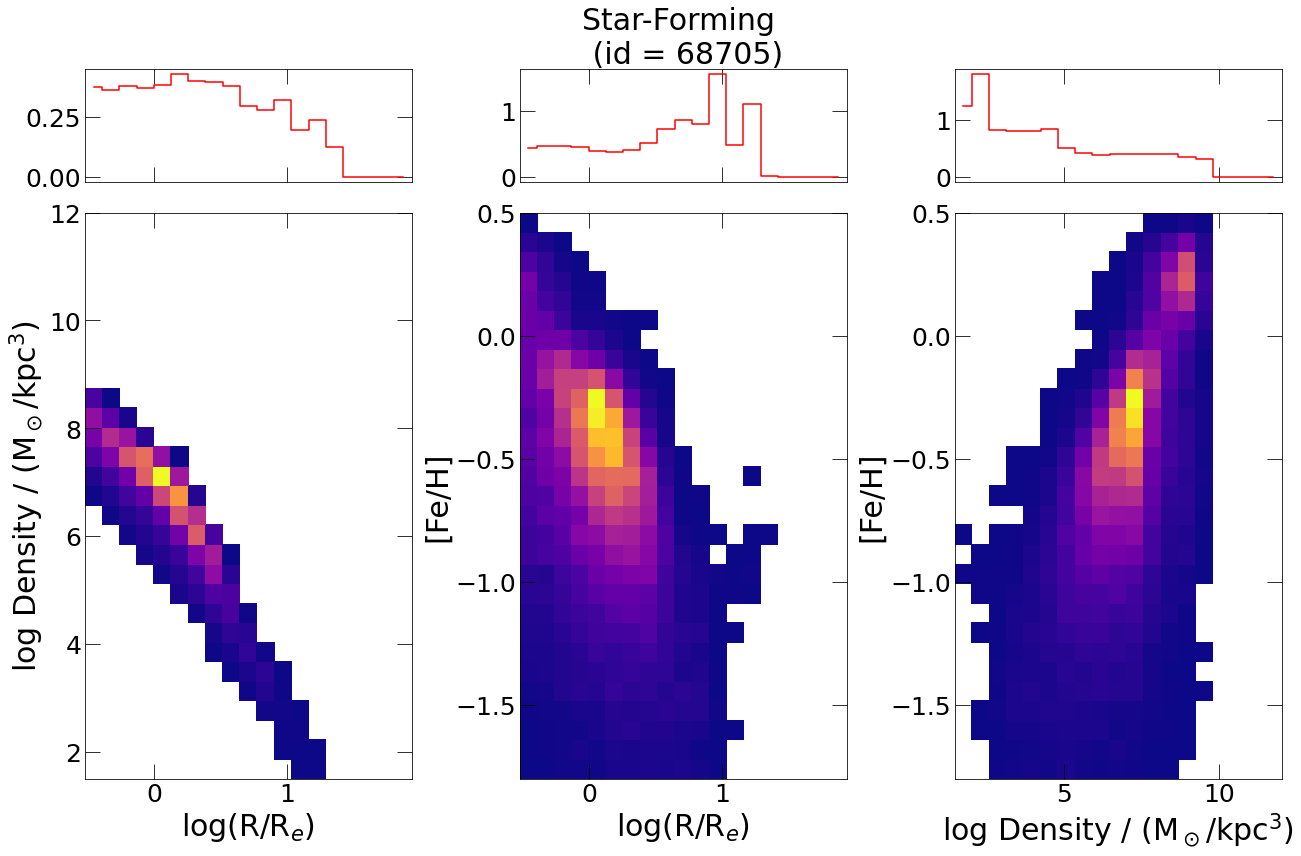

In [8]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 1, replace=False):
    logFeH, density, R = histmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    R_e = halfmass_rad_stars(id, redshift)
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(np.log10(R/R_e), np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(np.log10(R/R_e), logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

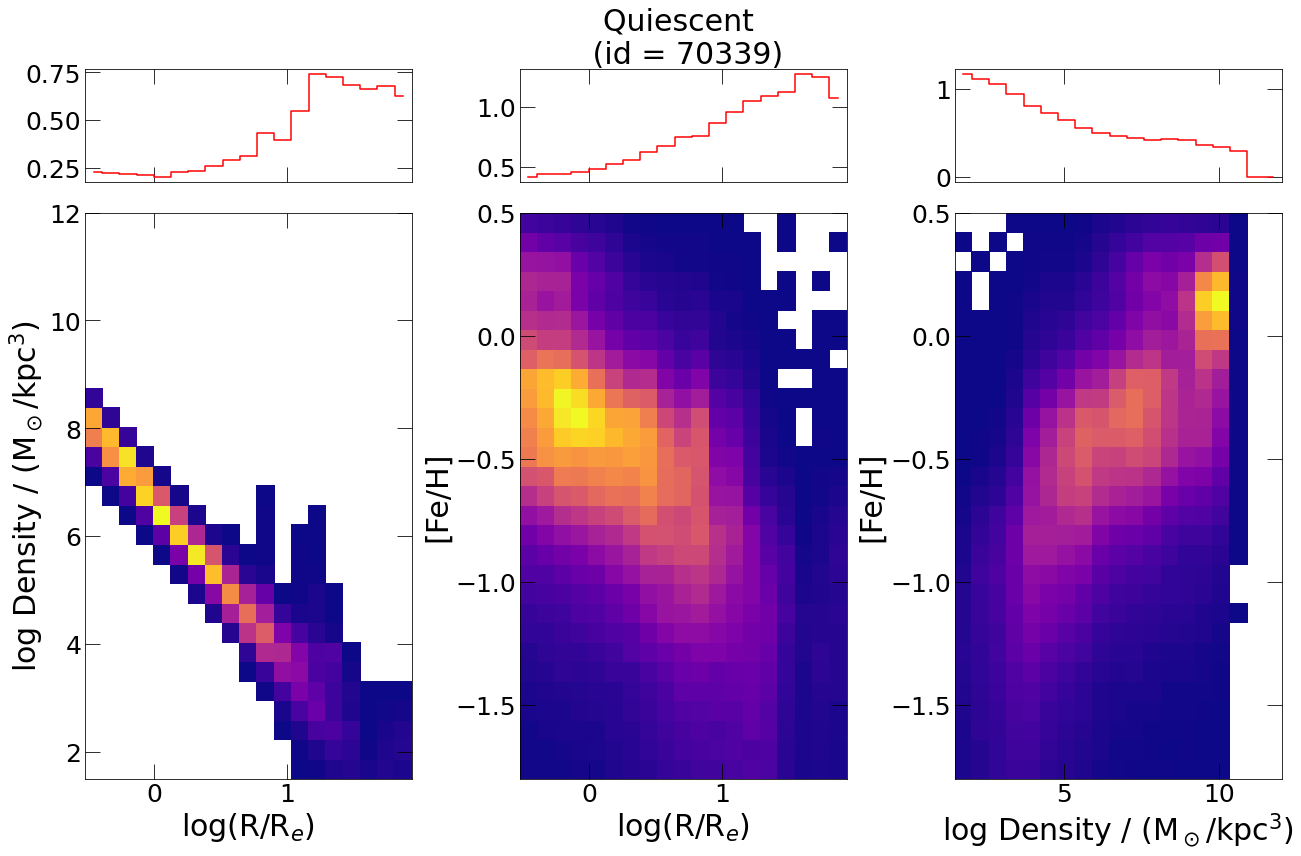

In [9]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

xbins = np.linspace(-0.52, 1.94, 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 1, replace=False):
    logFeH, density, R = histmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    R_e = halfmass_rad_stars(id, redshift)
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, np.log10(R/R_e)), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(np.log10(R/R_e), np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(np.log10(R/R_e), logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(-0.52, 1.94)
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(-0.52, 1.94)
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]", fontsize=fts)
ax2.set_xlabel('log(R/R$_e$)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

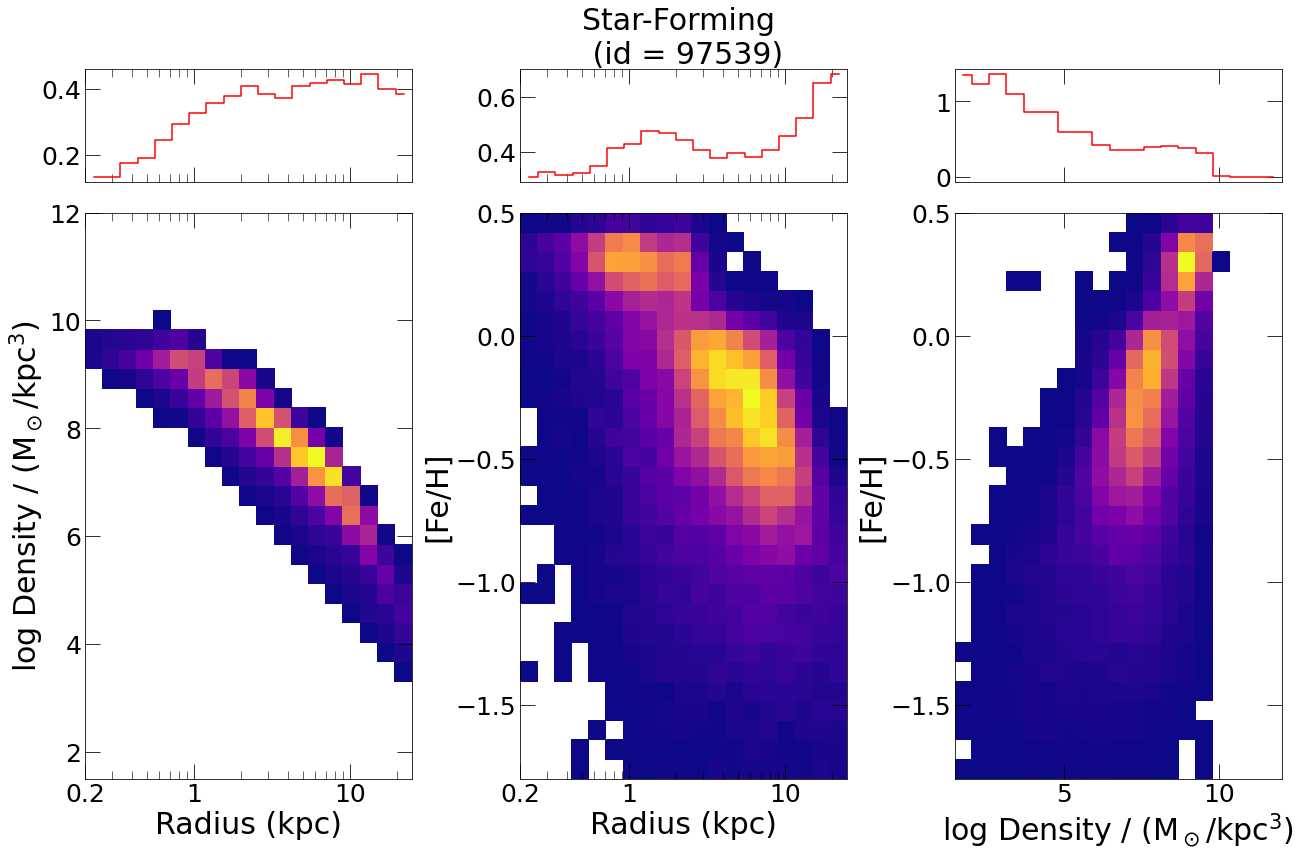

In [10]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 1, replace=False):
    logFeH, density, R = histmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

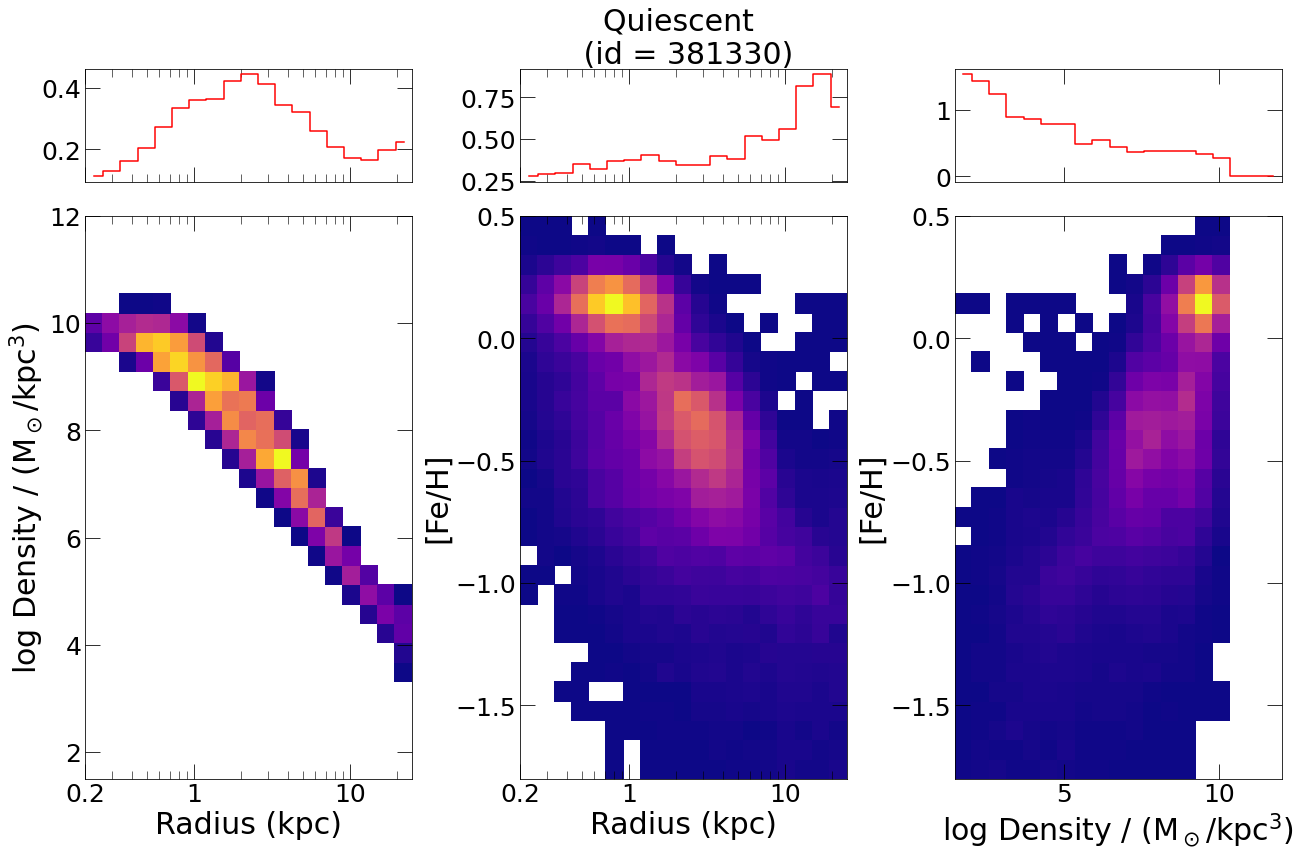

In [11]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 1, replace=False):
    logFeH, density, R = histmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

# Gas Metallicity

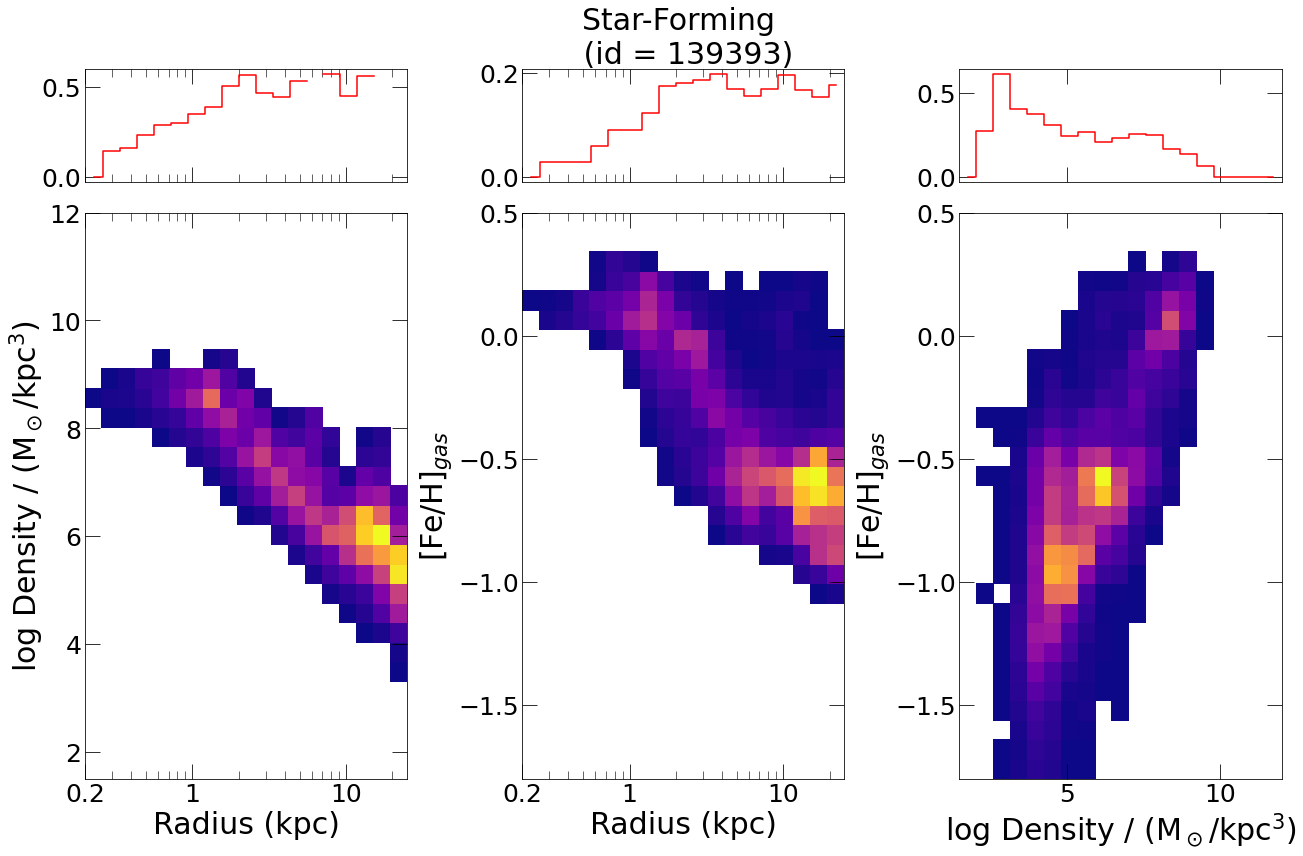

In [4]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 1, replace=False):
    logFeH, density, R = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

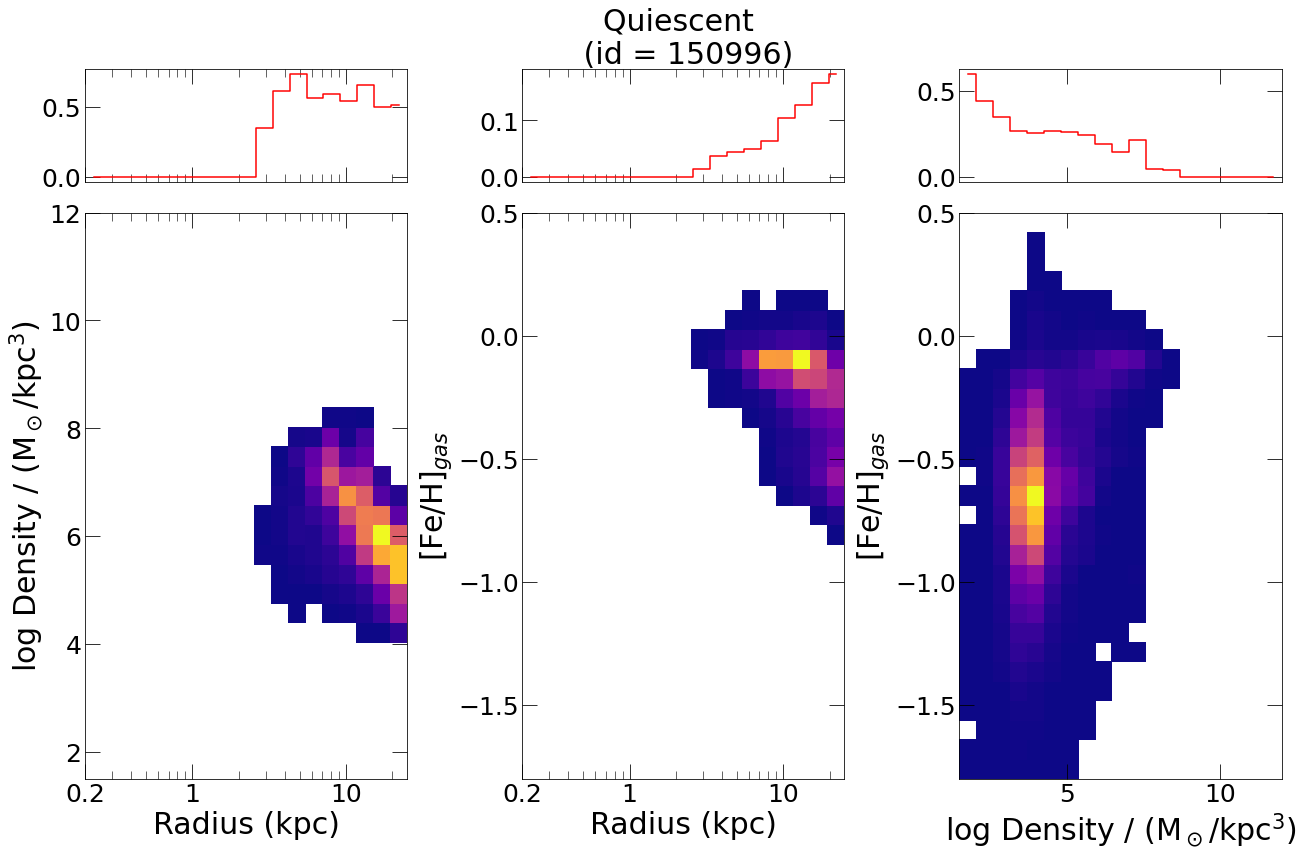

In [5]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 1, replace=False):
    logFeH, density, R = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
    number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (id = '+str(number)+')', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

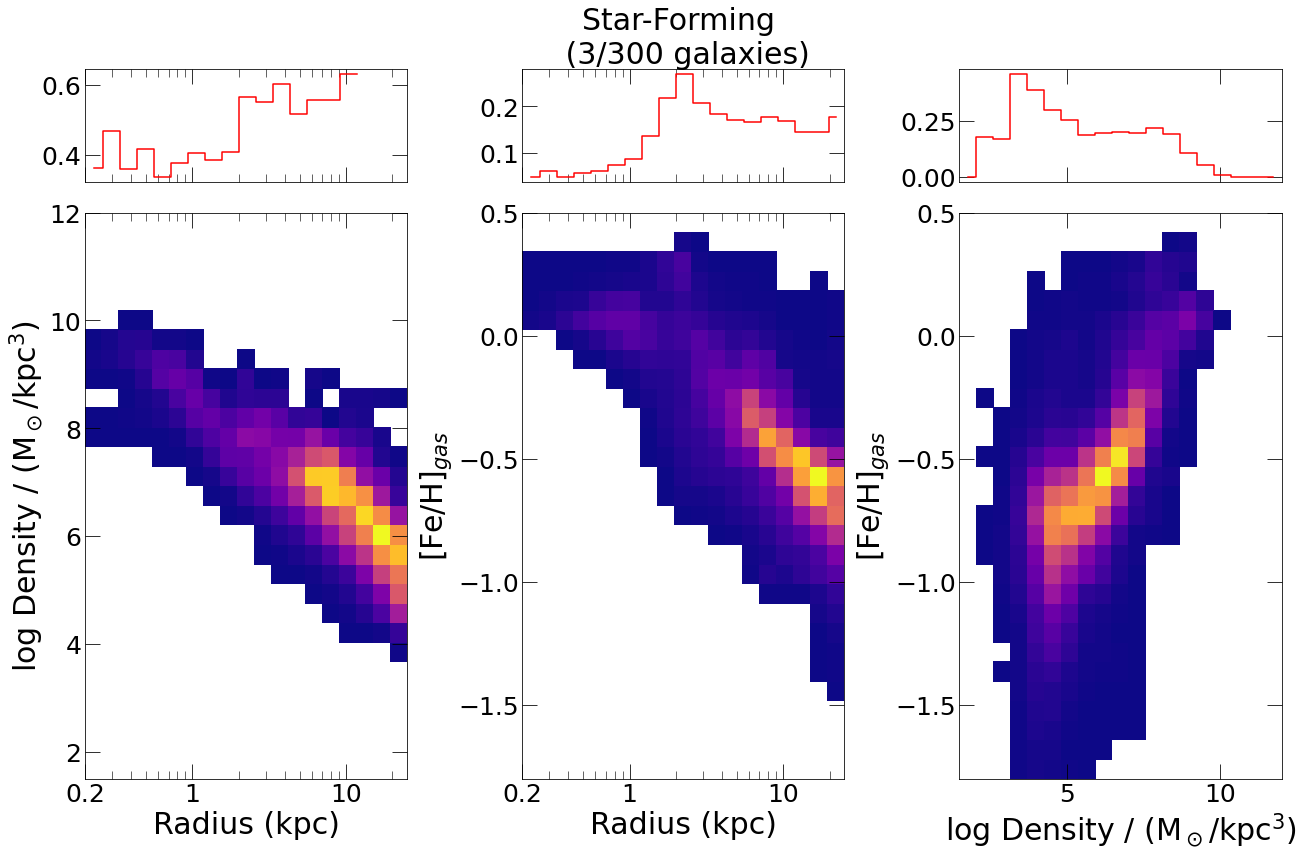

In [6]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[starforming_selection], 3, replace=False):
    logFeH, density, R = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
#     number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Star-Forming \n (3/'+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

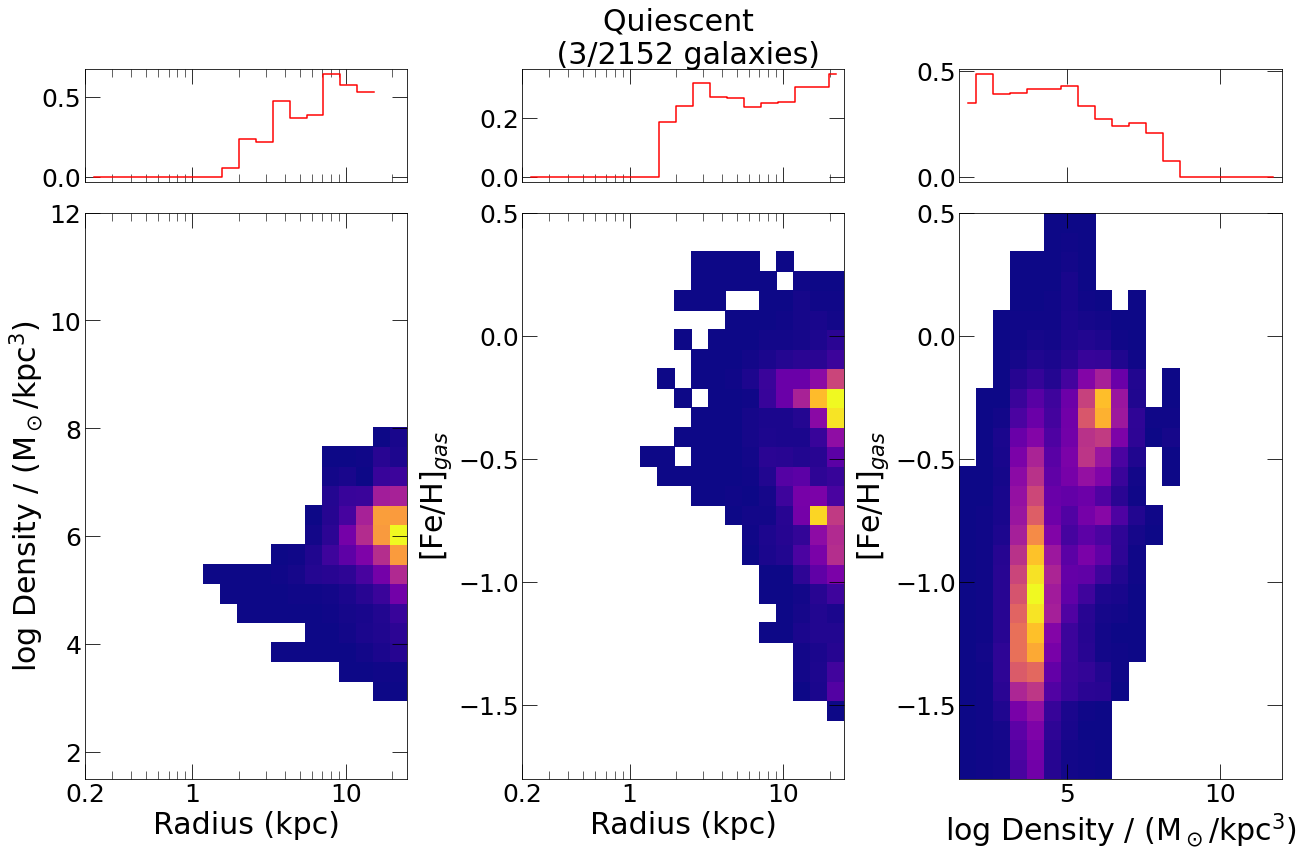

In [7]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie

#metallicity profiles
f, (axes) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(18, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap = plt.get_cmap('plasma')
norm = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(1.5, 12, 30)
metalbins = np.linspace(-1.8, 0.5, 30)
densitybins2 = np.linspace(1.5, 12, 20)

#z=2 star-forming galaxies
big_h = np.zeros((len(xbins)-1, len(ybins)-1))
big_h2 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h3 = np.zeros((len(densitybins2)-1, len(metalbins)-1))
big_density = np.zeros(0)
big_R = np.zeros(0)
big_FeH = np.zeros(0)
for id in np.random.choice(ids[quiescent_selection], 3, replace=False):
    logFeH, density, R = gasmetals_density_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    big_density = np.concatenate((big_density, np.log10(density)), axis=None)
    big_R = np.concatenate((big_R, R), axis=None)
    big_FeH = np.concatenate((big_FeH, logFeH), axis=None)
    h, _, _ = np.histogram2d(R, np.log10(density), bins=[xbins, ybins], density=False)#, len(percentiles))
    h2, _, _ = np.histogram2d(R, logFeH, bins=[xbins, metalbins], density=False)
    h3, _, _ = np.histogram2d(np.log10(density), logFeH, bins=[densitybins2, metalbins], density=False)
    big_h3 += h3
    big_h2 += h2
    big_h += h 
#     number = id

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
ybins_new = (ybins[1:]+ybins[:-1])/2
metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R, big_density, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R, big_FeH, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_density, big_FeH, 'std', bins=densitybins2)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(densitybins2_new, stat3, 'r', where='mid')

# plot big pixel maps
big_h[big_h==0] = np.nan
color=colormap(norm(big_h)).tolist()
color = tuple(color[0][:])
ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['0.2', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(1.5, 12)
ax1.set_ylabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

big_h2[big_h2==0] = np.nan
color=colormap(norm(big_h2)).tolist()
color = tuple(color[0][:])
ax2.pcolormesh(xbins, metalbins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['0.2', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-1.8, 0.5)
ax2.set_ylabel("[Fe/H]$_{gas}$", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(densitybins2, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(1.5, 12)
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("log Density / (M$_\odot$/kpc$^3$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]$_{gas}$', fontsize=fts)
ax3.set_ylim(-1.8, 0.5)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

sc2.set_title('Quiescent \n (3/'+str(len(ids[quiescent_selection]))+' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()